###  RANDOM FOREST INTERPRETATIONS

Implement interpretation methods on top of our RF.

- Confidence based on tree based variance
- Feature Importance
- Partial dependence
- Tree Interpreter

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append('../../FASTAI/fastai/')

In [4]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [7]:
df_raw = pd.read_feather('../../FASTAI/fastai/courses/ml1/tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [8]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

### RF

Code implemented during Fast.ai ML 1 course

In [9]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [10]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

### CONFIDENCE BASED ON TREE VARIANCE

In [11]:
import scipy.stats as st

class TreeConfidence:
    def __init__(self, model, X, y=None):
        self.X = X
        self.model = model
        self.y = y
    
    def get_preds(self):
        preds_arr = np.stack([t.predict(self.X) for t in self.model.trees])
        mean = np.mean(preds_arr, axis = 0)
        std = np.std(preds_arr, axis = 0)
        self.mean = mean
        self.std = std
        return list(zip(mean, std))
    
    def plot_CI(self, n=10, alpha=0.05):
        worst_idx = np.argsort(self.std)[::-1][:n]
        z = st.norm.ppf(1-alpha)
        plt.errorbar(range(n), self.mean[worst_idx], yerr=z*self.std[worst_idx], linestyle='None', marker='^')
        plt.xticks(range(n), worst_idx, rotation='vertical')
        plt.xlabel('Index')
        plt.ylabel('Prediction')
        if self.y is not None:
            plt.scatter(range(n), self.y[worst_idx], color='red')
        plt.title(f'Top {n} Inconfident Preds')
        plt.show()
        self.inconfident_idx = worst_idx

In [12]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [13]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

In [14]:
# tree_based_confidence takes a numpy array
X_valid_arr = np.array(X_valid[cols])
t_conf = TreeConfidence(ens, X=X_valid_arr, y=y_valid)

In [15]:
#return mean predictions and std through each tree estimation
preds_confidence = t_conf.get_preds()

In [16]:
#print first 10 validation prediction and their confidences
preds_confidence[:10]

[(9.47220518605317, 0.11817477418906022),
 (9.4872894849883895, 0.2150947939039578),
 (9.4785027119230474, 0.17415497790617179),
 (9.47220518605317, 0.11817477418906022),
 (9.4732554343846225, 0.081911482343672917),
 (9.4201450172278989, 0.089049231631374501),
 (9.5984479242095375, 0.063452144017706116),
 (9.4525468658151119, 0.19098843787997505),
 (9.5782359361493654, 0.21389384712238318),
 (9.526339911555997, 0.17508577776567533)]

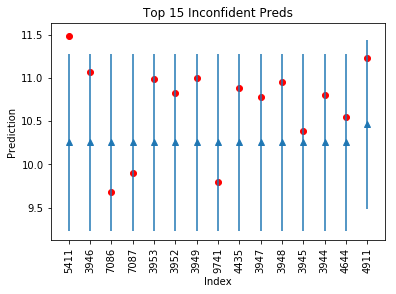

In [17]:
#plot most inconfident 10 predictions with indices
#set confidence level = 0.95
#these are the cases that our trees have the most varying predictions 
t_conf.plot_CI(n=15, alpha=0.05)

In [18]:
# we can grap the standard deviations of inconfident indices individually
t_conf.std[t_conf.inconfident_idx]

array([ 0.62048,  0.62048,  0.62048,  0.62048,  0.62048,  0.62048,  0.62048,  0.62048,  0.62048,  0.62048,
        0.62048,  0.62048,  0.62048,  0.62048,  0.59255])

In [19]:
t_conf.inconfident_idx

array([5411, 3946, 7086, 7087, 3953, 3952, 3949, 9741, 4435, 3947, 3948, 3945, 3944, 4644, 4911])

In [20]:
# take a look at these indices
# We can actually see that these predictions have many common things 
# Such like yearmade, productsize, machinemeter so on so forth
# so its good practice to take a look at the predictions that we are not confident
X_valid[cols].iloc[t_conf.inconfident_idx]

,MachineID,YearMade,MachineHoursCurrentMeter,ProductSize,Enclosure,Coupler_System,saleYear
394536,1828168,1985,0.0,2,1,0,2011
393071,1924697,1984,0.0,2,6,0,2011
396211,1813643,1984,0.0,2,1,0,2011
396212,1883763,1984,0.0,2,1,0,2011
393078,1791687,1984,0.0,2,3,0,2011
393077,1836132,1985,0.0,2,6,0,2011
393074,1875745,1984,0.0,2,3,0,2011
398866,1806392,1984,0.0,2,6,0,2011
393560,1925412,1985,0.0,2,3,0,2011
393072,1939065,1984,0.0,2,6,0,2011


### FEATURE IMPORTANCE

**Simple But Brilliant**

The idea is so simple, its brilliant; you model once, predict once to get a benchmark score, and finally predict hundreds of times for each variable in the model while randomizing that variable. If the variable being randomized hurts the model’s benchmark score, then its an important variable. If, on the other hand, nothing changes, or it beats the benchmark, then its a useless variable. By running this hundreds of times for each variable, you can paint a clear picture of what variable is affecting the model and to what degree. The beauty of this approach is that it is model agnostic as everything happens after the modeling phase.

In [21]:
# define a metric for baseline score
# we will go with rmse since as competition required 
# but any evaluation function can be defined
def feval(y_true, y_pred): return np.sqrt(metrics.mean_squared_error(y_pred=y_pred, y_true=y_true))

In [22]:
# takes randomforest model
# data to predict and true values
# any custome feval function
# and bool whether feval is better as a small or larger value
def plot_feature_imp(ens, X, y, feval, small_better=True):
    preds = ens.predict(np.array(X))
    baseline = feval(y_pred=preds, y_true=y_valid)
    #get feat imp
    feat_imp = {}
    for n, c in valid_data.items():
        valid_data_tmp = valid_data.copy()
        valid_data_tmp[n] = np.random.permutation(c)
        y_preds = ens.predict(np.array(valid_data_tmp))
        new_eval = feval(y_preds, y_valid)
        if small_better:
            delta = new_eval - baseline
        else:
            delta = baseline - new_eval
        feat_imp[n] = delta
    #plot 
    D = feat_imp
    plt.bar(range(len(D)), D.values(), align='center')
    plt.xticks(range(len(D)), D.keys(), rotation=75)
    plt.title('Feature Importance')
    plt.ylabel('Delta')
    plt.axhline(y=0, color='black', alpha=0.4)
    return feat_imp

In [23]:
valid_data = X_valid[cols]
preds = ens.predict(np.array(valid_data))

{'Coupler_System': 0.33379034657914769,
 'Enclosure': 0.043900893876550273,
 'MachineHoursCurrentMeter': -0.001454594528879749,
 'MachineID': 0.019066057979239381,
 'ProductSize': 0.22397207766894373,
 'YearMade': 0.16133200491582739,
 'saleYear': 0.0016635653395752903}

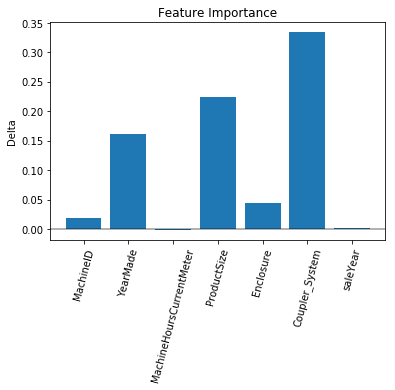

In [24]:
# MachineHoursCurrentMeter can be dropped
plot_feature_imp(ens, valid_data, y_valid, feval, True)

### PARTIAL DEPENDENCE PLOT

A good read related to PDP and ICE plots: https://arxiv.org/pdf/1309.6392.pdf

When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

**Important Note:** These plots require model error to be as low as possible. This makes sense since partial dependence depends on predictions of training data.

### Problems with PDP Plots

In fact, the original work introducing PDPs argues that the PDP can be a useful summary
for the chosen subset of variables if their dependence on the remaining features is not too
strong. When the dependence is strong, however – that is, when interactions are present –
the PDP can be misleading. Nor is the PDP particularly effective at revealing extrapolations
in X -space. ICE plots are intended to address these issues.

In [26]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 20000)

In [166]:
#choosing a small is recommended 
def pdp_plot(m, x, target_feature, num_grids=None ,n=None):
    x_tmp = x.copy()
    x_tmp = x_tmp.sample(n=n)
    levels = np.unique(x_tmp[target_feature])
    if num_grids: levels = levels[::round(len(levels)/num_grids)]
    tmp_preds = []
    for l in levels:
        x_tmp[target_feature] = l
        tmp_preds.append(ens.predict(np.array(x_tmp)))
        
    tmp_preds = np.array(tmp_preds)
    
    means = np.mean(tmp_preds, axis=1)
    means -= means[0]
    tmp_preds -= tmp_preds[0]
    
    plt.hlines(y=0, xmin=levels[0], xmax=levels[-1], linestyles='dotted', colors='red')
    plt.plot(levels, np.array(tmp_preds), alpha=0.1, color='skyblue')
    plt.plot(levels, means)
    plt.scatter(levels, means, color='black')
    plt.title(f'PDP + ICE Plot {target_feature}')
    plt.xticks(levels)

    return levels 

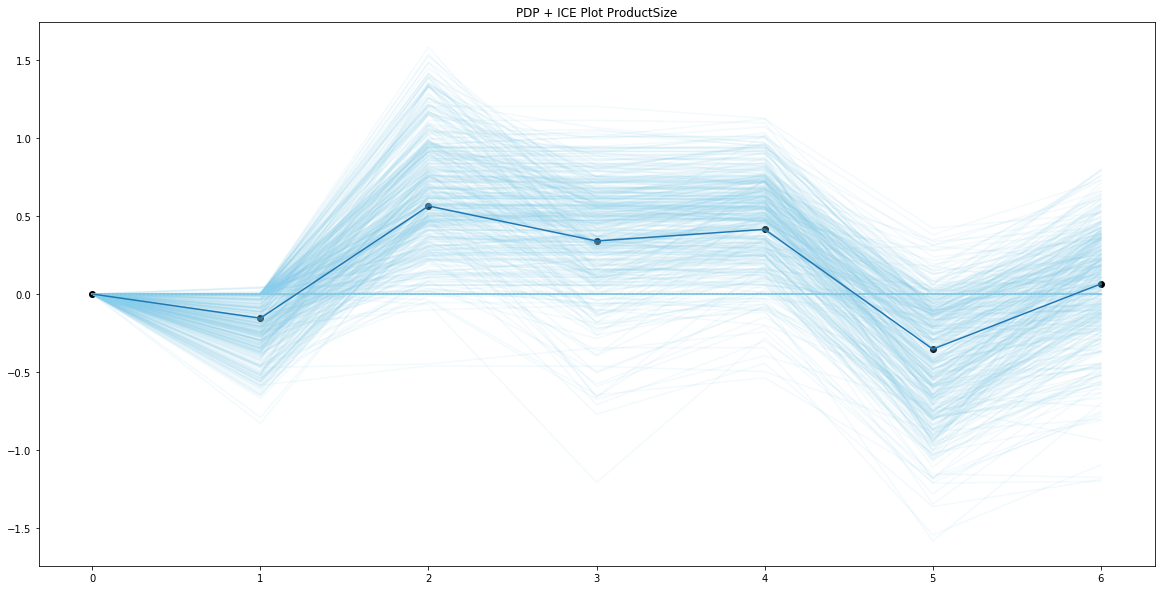

In [204]:
matplotlib.rcParams['figure.figsize'] = (20, 10)
x = X_train[cols][X_train.YearMade > 1920]
levels = pdp_plot(ens, x, 'ProductSize', num_grids= 10,n=500)

In [174]:
#take target_features tuple/list
#take num_grids tuple/list

def pdp_2way_plot(m, x, target_features, num_grids=None ,n=None):
    pass

In [210]:
x = ens.x

In [211]:
x_tmp = x.copy()
x_tmp = x_tmp.sample(n=500)

In [212]:
target_features = ['YearMade', 'Enclosure']

In [213]:
levels1 = np.unique(x_tmp[target_features[0]])
levels2 = np.unique(x_tmp[target_features[1]])

In [214]:
t1 = target_features[0]
t2 = target_features[1]
tmp_preds = []
for l1 in levels1:
    x_tmp[t1] = l1
    for l2 in levels2:
        x_tmp[t2] = l2
        tmp_preds.append(np.mean(ens.predict(np.array(x_tmp))))
        

In [216]:
preds = np.array(tmp_preds).reshape(len(levels1), len(levels2))

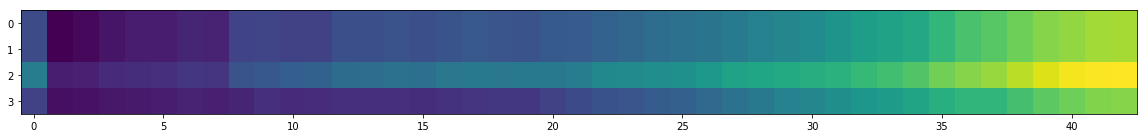

In [220]:
plt.imshow(preds.T)

In [219]:
preds

array([[  9.76755,   9.76755,  10.06558,   9.70831],
       [  9.40134,   9.40134,   9.53329,   9.46512],
       [  9.43555,   9.43555,   9.54456,   9.47749],
       [  9.4933 ,   9.4933 ,   9.58911,   9.50435],
       [  9.52024,   9.52024,   9.60898,   9.51575],
       [  9.52853,   9.52853,   9.61581,   9.5279 ],
       [  9.56121,   9.56121,   9.64875,   9.55726],
       [  9.55381,   9.55381,   9.64606,   9.54181],
       [  9.7197 ,   9.7197 ,   9.80803,   9.56428],
       [  9.72775,   9.72775,   9.83357,   9.61434],
       [  9.70556,   9.70556,   9.87325,   9.58795],
       [  9.70883,   9.70883,   9.88846,   9.5981 ],
       [  9.78278,   9.78278,   9.95649,   9.61223],
       [  9.78212,   9.78212,   9.9605 ,   9.61241],
       [  9.80139,   9.80139,   9.98919,   9.61529],
       [  9.78469,   9.78469,   9.97487,   9.607  ],
       [  9.81046,   9.81046,  10.02318,   9.62337],
       [  9.83806,   9.83806,  10.03643,   9.64395],
       [  9.81674,   9.81674,  10.03269,   9.6

In [173]:
levels = np.unique(x_tmp[target_feature])
if num_grids: levels = levels[::round(len(levels)/num_grids)]
tmp_preds = []
for l in levels:
    x_tmp[target_feature] = l
    tmp_preds.append(ens.predict(np.array(x_tmp)))

tmp_preds = np.array(tmp_preds)

means = np.mean(tmp_preds, axis=1)
means -= means[0]
tmp_preds -= tmp_preds[0]